In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import cpu_count
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, HalvingGridSearchCV
from src.utils import load_data, initialize_model_pipeline, cross_validate_model
from sklearn.metrics import accuracy_score, classification_report
from os import cpu_count

In [40]:
data = pd.read_csv('../data/thea.csv')
X = data.drop('increase_stock', axis=1)
Y = data['increase_stock']
data.shape

(1600, 43)

In [41]:
bs_results = []
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'estimator__max_depth': [2, 3, 4],  # Example decision tree hyperparameter
}

for i in range(100):
    print(f'{i+1}/100')
    result = {}
    x_train, x_test, y_train, y_test = train_test_split(X,Y,
                                                        test_size=1/16,
                                                        random_state=i+1)
    kf = KFold(n_splits=150, shuffle=False)
    base_m = DecisionTreeClassifier(random_state=123)
    ada_model = AdaBoostClassifier(estimator=base_m)
    search = HalvingGridSearchCV(ada_model,
                                 param_grid=param_grid,
                                 cv=kf,
                                 scoring='accuracy',
                                 n_jobs=cpu_count()-1)
    search.fit(x_train,y_train)
    result['accuracy'] = accuracy_score(y_test, search.best_estimator_.predict(x_test))
    result['optimistic_accuracy'] = search.best_score_
    result['class_report'] = classification_report(y_test, search.best_estimator_.predict(x_test))
    result['best_params'] = search.best_params_
    result['model'] = search.best_estimator_
    bs_results.append(result)
    

1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100
100/100


In [43]:
results_df = pd.DataFrame(bs_results)
# results_df.to_pickle('../data/ada_optimal_results.pkl')
results_df

,accuracy,optimistic_accuracy,class_report,best_params,model
0,0.91,0.890000,precision recall f1-score ...,"{'estimator__max_depth': 2, 'learning_rate': 0...","(DecisionTreeClassifier(max_depth=2, random_st..."
1,0.82,0.890000,precision recall f1-score ...,"{'estimator__max_depth': 2, 'learning_rate': 0...","(DecisionTreeClassifier(max_depth=2, random_st..."
2,0.93,0.865000,precision recall f1-score ...,"{'estimator__max_depth': 2, 'learning_rate': 0...","(DecisionTreeClassifier(max_depth=2, random_st..."
3,0.91,0.860000,precision recall f1-score ...,"{'estimator__max_depth': 3, 'learning_rate': 0...","(DecisionTreeClassifier(max_depth=3, random_st..."
4,0.89,0.886667,precision recall f1-score ...,"{'estimator__max_depth': 2, 'learning_rate': 0...","(DecisionTreeClassifier(max_depth=2, random_st..."
...,...,...,...,...,...
95,0.88,0.888333,precision recall f1-score ...,"{'estimator__max_depth': 3, 'learning_rate': 0...","(DecisionTreeClassifier(max_depth=3, random_st..."
96,0.88,0.876667,precision recall f1-score ...,"{'estimator__max_depth': 2, 'learning_rate': 0...","(DecisionTreeClassifier(max_depth=2, random_st..."
97,0.84,0.880000,precision recall f1-score ...,"{'estimator__max_depth': 2, 'learning_rate': 0...","(DecisionTreeClassifier(max_depth=2, random_st..."
98,0.91,0.883333,precision recall f1-score ...,"{'estimator__max_depth': 3, 'learning_rate': 0...","(DecisionTreeClassifier(max_depth=3, random_st..."


In [44]:
print(f'mew out of sample accuracy - mew optimistic accuracy = {np.mean(results_df["accuracy"] - results_df["optimistic_accuracy"])}')
results_df[['accuracy','optimistic_accuracy']].mean()

mew out of sample accuracy - mew optimistic accuracy = -0.0015000000000000013


accuracy               0.8806
optimistic_accuracy    0.8821
dtype: float64

In [45]:
# noinspection PyArgumentList
quantile_5 = np.percentile(results_df['accuracy'], 5, interpolation="linear")
# noinspection PyArgumentList
quantile_95 = np.percentile(results_df['accuracy'], 95, interpolation="linear")
print(f'~95% CI on out of sample accuracy [{quantile_5}, {quantile_95}]')

~95% CI on out of sample accuracy [0.8295, 0.93]


Text(0.5, 1.0, 'Density: Out of Sample Accuracy vs. Optimistic Accuracy')

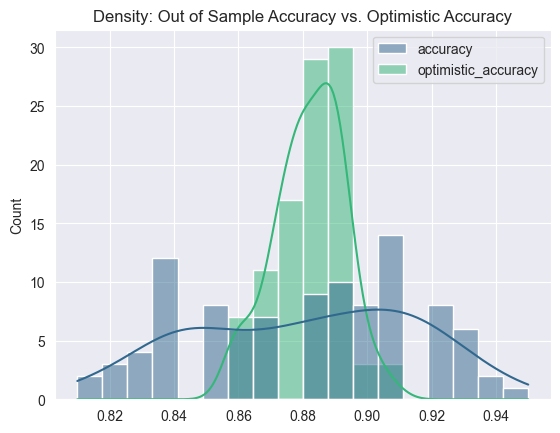

In [46]:
from seaborn import histplot
import matplotlib.pyplot as plt

histplot(data=results_df[['accuracy', 'optimistic_accuracy']], kde=True, palette='viridis')
plt.title('Density: Out of Sample Accuracy vs. Optimistic Accuracy')

In [47]:
#ex of how we can see the optimal results of hyper params
hyper_params_df = pd.DataFrame(results_df['best_params'].tolist())
hyper_params_df.describe()

,estimator__max_depth,learning_rate,n_estimators
count,100.000000,100.000000,100.0
mean,2.890000,0.030700,155.0
std,0.790026,0.038066,50.0
min,2.000000,0.010000,100.0
25%,2.000000,0.010000,100.0
50%,3.000000,0.010000,200.0
75%,4.000000,0.010000,200.0
max,4.000000,0.100000,200.0


In [ ]:
# best score 0.8961111111111112
# {'base_estimator__max_depth': 4, 'learning_rate': 0.01, 'n_estimators': 200}

# best score 0.8805555555555556
# {'estimator__max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 100}
#SAMERUN
# best score 0.8994444444444446
# {'estimator__max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 100}
#SAMERUN
# best score 0.8805555555555556
# {'estimator__max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 50}
#SAMERUN Full GS
# best score 0.8913333333333334
# {'estimator__max_depth': 4, 'learning_rate': 0.01, 'n_estimators': 50}

# best score 0.8866666666666667
# {'estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 200}